# HW03: Distance and Topic Model

Remember that these homework work as a completion grade. **You can skip one section without losing credit.**

## Load and Pre-process Text

In [270]:
#Import the AG news dataset (same as hw01)
#Download them from here 
#!wget https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv

import pandas as pd
import nltk
df = pd.read_csv('train.csv')

df.columns = ["label", "title", "lead"]
label_map = {1:"world", 2:"sport", 3:"business", 4:"sci/tech"}
def replace_label(x):
	return label_map[x]
df["label"] = df["label"].apply(replace_label) 
df["text"] = df["title"] + " " + df["lead"]
df.head()

,label,title,lead,text
0,business,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Carlyle Looks Toward Commercial Aerospace (Reu...
1,business,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Oil and Economy Cloud Stocks' Outlook (Reuters...
2,business,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Iraq Halts Oil Exports from Main Southern Pipe...
3,business,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","Oil prices soar to all-time record, posing new..."
4,business,"Stocks End Up, But Near Year Lows (Reuters)",Reuters - Stocks ended slightly higher on Frid...,"Stocks End Up, But Near Year Lows (Reuters) Re..."


In [271]:
import spacy
dfs = df.sample(200, random_state=102)
nlp = spacy.load('en_core_web_sm')
from sklearn.feature_extraction.text import TfidfVectorizer

##TODO pre-process text as you did in HW02
dfs["processed"] = dfs["text"].apply(lambda x: nlp(x))
dfs['meaningful_toks'] = dfs['processed'].apply(lambda doc: [w.lemma_.lower() for w in doc if not w.is_stop and not w.is_punct and not w.is_digit])
dfs["input_TFIDF"] = dfs["meaningful_toks"].apply(lambda x: " ".join(x))

In [272]:
dfs.head()

,label,title,lead,text,processed,meaningful_toks,input_TFIDF
102378,business,GE Gives Airline Help On Leases,"ARLINGTON, Va. - US Airways Group said Friday ...","GE Gives Airline Help On Leases ARLINGTON, Va....","(GE, Gives, Airline, Help, On, Leases, ARLINGT...","[ge, give, airline, help, leases, arlington, v...",ge give airline help leases arlington va. airw...
50436,sport,Ravens #39; Battle Plans for Chiefs,"Once again, Ravens Insider staffer Dev Panchwa...",Ravens #39; Battle Plans for Chiefs Once again...,"(Ravens, #, 39, ;, Battle, Plans, for, Chiefs,...","[ravens, battle, plans, chiefs, ravens, inside...",ravens battle plans chiefs ravens insider staf...
61913,world,Rain in Boston Postpones BoSox-Yanks Game,BOSTON - Steady rain Friday night forced major...,Rain in Boston Postpones BoSox-Yanks Game BOST...,"(Rain, in, Boston, Postpones, BoSox, -, Yanks,...","[rain, boston, postpones, bosox, yanks, game, ...",rain boston postpones bosox yanks game boston ...
16282,world,Terrorists Storm School in Southern Russia,Armed terrorists stormed a school in southern ...,Terrorists Storm School in Southern Russia Arm...,"(Terrorists, Storm, School, in, Southern, Russ...","[terrorists, storm, school, southern, russia, ...",terrorists storm school southern russia armed ...
77900,business,Surge in car sales spurs economy,The final snapshot of the economy before Elect...,Surge in car sales spurs economy The final sna...,"(Surge, in, car, sales, spurs, economy, The, f...","[surge, car, sale, spur, economy, final, snaps...",surge car sale spur economy final snapshot eco...


In [273]:
##TODO vectorize the pre-processed text using TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df=0.01, # When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold.
                        max_df=0.9,  # When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words).
                        max_features=1000,
                        stop_words='english',
                        use_idf=True, # the new piece
                        ngram_range=(1,1))

X_tfidf = tfidf.fit_transform(dfs['input_TFIDF'])

In [274]:
# Some exploration:
# The weights of each feature computed by the fit method call are stored in a model attribute:
# print(tfidf.idf_)
# tfidf.get_feature_names_out()
# This is the weighted counts of words in the first document:
# X_tfidf[0].toarray()
# tfidf matrix for first two documents and first 40 features
# X_tfidf.toarray()[:2, :40]

X_tfidf = X_tfidf.toarray()

## Cosine Similarity and PCA

cosine_similarity computes the L2-normalized dot product of vectors. This kernel is a popular choice for computing the similarity of documents represented as tf-idf vectors.

https://scikit-learn.org/stable/modules/metrics.html#cosine-similarity

In [275]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

##TODO compute the cosine similarity for the first 200 snippets and for the first snippet, show the three most similar snippets and their respective cosine similarity scores

# Compute cosine similarity matrix
cos_sim_matrix = cosine_similarity(X_tfidf)
#print(cos_sim_matrix[:1])

# Sort cosine similarity matrix for each document in descending order
cos_sim_sorted = np.argsort(-cos_sim_matrix)
#print(cos_sim_sorted[:1]) # the first element is always the snippet itself

# Select top three similar documents for each document
print(f"\nMost similar documents to: \n'{dfs.iloc[0]['input_TFIDF']}':\n")

for j in cos_sim_sorted[0][1:4]: # start with 1 to skip the first snippet itself
    print(f"Cosine similarity: '{round(cos_sim_matrix[0,j], 3)}' - Snippet: '{dfs.iloc[j]['input_TFIDF']}'")


Most similar documents to: 
'ge give airline help leases arlington va. airways group say friday reach agreement general electric co. aircraft leasing financing term help airline low cost reduce debt seek avoid liquidation':

Cosine similarity: '0.171' - Snippet: 'start offer low power personal supercomputers   new york reuters lower electrical power consumption   great datum processing oomph help new class   desktop supercomputer unveil monday turn conventional   industry logic head designer'
Cosine similarity: '0.164' - Snippet: 'delta cut flights okc dallas fort worth oklahoma city oklahoma lose delta air lines flight dallas fort worth international airport airline restructure try avoid bankruptcy'
Cosine similarity: '0.152' - Snippet: 'update air seek court impose cut wage benefit bankrupt airways group inc. uairq.ob quote profile research thursday ask court impose wage benefit cut union employee save'


In [276]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3,svd_solver='randomized')

##TODO reduce the vectorized data using PCA
Xpca = pca.fit_transform(X_tfidf)
pca.explained_variance_ratio_

array([0.01662343, 0.01414936, 0.01337693])

In [277]:
##TODO compute again cosine similarity with the reduced version for the first 200 snippets

# Compute cosine similarity matrix
cos_sim_matrix = cosine_similarity(Xpca)

# Sort cosine similarity matrix for each document in descending order
cos_sim_sorted = np.argsort(-cos_sim_matrix)

##TODO for the first snippet, show again its three most similar snippets
# Select top three similar documents for each document
print(f"\nMost similar documents to: \n'{dfs.iloc[0]['input_TFIDF']}':\n")

for j in cos_sim_sorted[0][1:4]: # start with 1 to skip the first snippet itself
    print(f"Cosine similarity: '{round(cos_sim_matrix[0,j], 3)}' - Snippet: '{dfs.iloc[j]['input_TFIDF']}'")


Most similar documents to: 
'ge give airline help leases arlington va. airways group say friday reach agreement general electric co. aircraft leasing financing term help airline low cost reduce debt seek avoid liquidation':

Cosine similarity: '0.977' - Snippet: 'north korean refugee enter south korean consulate beijing beijing group north korean refugee attempt enter south korean consulate building beijing manage shelter inside south korean official medium say'
Cosine similarity: '0.96' - Snippet: 'internet satire sequel parodies u.s. newsmakers anick jesdanun     new york ap creator political satire sensation land come sequel set tune dixie     online animation good dc feature presidential vice presidential candidate attorney general john ashcroft cbs news anchor dan filmmaker michael moore talk host rush limbaugh jane fonda     land basically president bush john kerry say evan spiridellis co produce cartoon brother gregg'
Cosine similarity: '0.947' - Snippet: 'u.n. deliver aid hait

Compare the cosine similarity before and after PCA reduction. Did the results change? 

Yes, the cosine similarities are much higher now and the most similar snippets also changes.

## Clustering

In [278]:
# Instead of tfidf, try with count vectorizer
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer(min_df=0.01, # at min 1% of docs
                        max_df=.9,  
                        max_features=1000,
                        stop_words='english',
                        ngram_range=(1,3))
X = vec.fit_transform(dfs['input_TFIDF'])

In [279]:
# !pip install scikit-learn-extra
from sklearn_extra.cluster import KMedoids

##TODO create the clusters found with k-medoids clustering and 5 clusters
kmed = KMedoids(n_clusters=3)
kmed.fit(X)
doc_clusters = kmed.labels_.tolist()
dfs['cluster_medoid'] = doc_clusters

In [280]:
##TODO create the clusters found with k-means clustering and 5 clusters
from sklearn.cluster import KMeans
km = KMeans(n_clusters=5, n_init=10)
km.fit(X)
doc_clusters = km.labels_.tolist()
dfs['cluster_means'] = doc_clusters

(200, 888)
(200, 2)


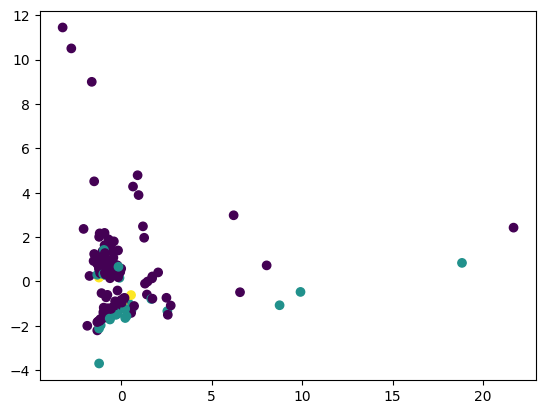

In [281]:
##TODO visualize the k-medoids clustering results through Isomap (first reduce the dimensionality to 2 using Isomap, then use scatter plot (plt.scatter()) to visualize)

# Reduce dimensionality to 2
from sklearn.manifold import Isomap
print(X.shape)
embedding = Isomap(n_components=2)
X_transformed = embedding.fit_transform(X)
print(X_transformed.shape)

# Plot the data in the reduced two-dimensional space
import matplotlib.pyplot as plt
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=dfs['cluster_medoid'])
plt.show()

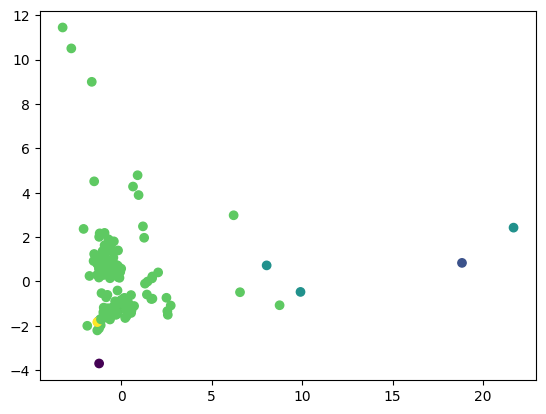

In [282]:
##TODO similarly, visualize the k-means results

plt.scatter(X_transformed[:,0], X_transformed[:,1], c=dfs['cluster_means'])
plt.show()

## Topic Modeling: LDA

For this part you will need to use LDA Mallet. If you cannot have Mallet run, you can use the simple LDA algorithm 

In [283]:
from gensim.corpora import Dictionary
from gensim.models.wrappers import LdaMallet
from gensim.models.coherencemodel import CoherenceModel

##TODO create a dictionary with the pre-processed tokenized text and filter it according to frequencies and keeping 1000 vocabularies

# clean document
#from gensim.utils import simple_preprocess
from spacy.tokenizer import Tokenizer
from tqdm import tqdm as tq

def tokenize(x, nlp):
    # lemmatize and lowercase without stopwords, punctuation and numbers
    return [w.lemma_.lower() for w in nlp(x) if not w.is_stop and not w.is_punct and not w.is_digit and len(w) > 2]

# split into paragraphs
doc_clean = []
for doc in tq(dfs['text']):
    # split by paragraph
    for paragraph in doc.split("\n\n"):
        doc_clean.append(tokenize(paragraph, nlp))
print(doc_clean[:2])

# randomize document order
from random import shuffle
shuffle(doc_clean)

# creating the term dictionary
from gensim import corpora
dictionary = corpora.Dictionary(doc_clean)
# filter extremes, drop all words appearing in less than 10 paragraphs and all words appearing in at least every third paragraph
dictionary.filter_extremes(keep_n=1000)
print(len(dictionary))

100%|██████████| 200/200 [00:02<00:00, 81.31it/s]

[['give', 'airline', 'help', 'leases', 'arlington', 'va.', 'airways', 'group', 'say', 'friday', 'reach', 'agreement', 'general', 'electric', 'co.', 'aircraft', 'leasing', 'financing', 'term', 'help', 'airline', 'low', 'cost', 'reduce', 'debt', 'seek', 'avoid', 'liquidation'], ['ravens', 'battle', 'plans', 'chiefs', 'ravens', 'insider', 'staffer', 'dev', 'panchwagh', 'break', 'upcoming', 'ravens', 'game', 'thos', 'week', 'defeat', 'chiefs', 'monday', 'night']]
147


In [284]:
##TODO create the doc_term_matrix
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

In [285]:
##TODO train a LDA Mallet model with 5, 10 and 15 topics

# LDA Mallet did not work, use simple LDA instead
# train LDA with 10 topics and print 
from gensim.models.ldamodel import LdaModel
lda = LdaModel(doc_term_matrix, num_topics=5, 
               id2word = dictionary, passes=3)
lda.show_topics(formatted=True)

[(0,
  '0.041*"new" + 0.040*"say" + 0.030*"reuters" + 0.024*"start" + 0.024*"inc." + 0.023*"win" + 0.022*"quot" + 0.022*"lt;a" + 0.021*"company" + 0.020*"night"'),
 (1,
  '0.086*"39;s" + 0.038*"say" + 0.028*"bank" + 0.022*"corp." + 0.022*"economy" + 0.021*"time" + 0.020*"world" + 0.020*"international" + 0.019*"friday" + 0.019*"fall"'),
 (2,
  '0.035*"high" + 0.034*"state" + 0.030*"city" + 0.030*"yesterday" + 0.029*"sale" + 0.029*"chief" + 0.027*"group" + 0.025*"report" + 0.023*"work" + 0.023*"percent"'),
 (3,
  '0.037*"say" + 0.034*"39;s" + 0.031*"year" + 0.028*"oil" + 0.025*"new" + 0.025*"reuters" + 0.024*"take" + 0.023*"industry" + 0.022*"official" + 0.021*"stock"'),
 (4,
  '0.056*"year" + 0.040*"bush" + 0.037*"39;s" + 0.035*"president" + 0.033*"say" + 0.029*"win" + 0.025*"friday" + 0.025*"school" + 0.023*"set" + 0.022*"want"')]

In [286]:
lda = LdaModel(doc_term_matrix, num_topics=10, 
               id2word = dictionary, passes=3)
lda.show_topics(formatted=True)

[(0,
  '0.082*"year" + 0.052*"new" + 0.029*"game" + 0.028*"friday" + 0.025*"good" + 0.025*"fall" + 0.024*"want" + 0.019*"technology" + 0.018*"39;s" + 0.016*"report"'),
 (1,
  '0.046*"say" + 0.037*"win" + 0.035*"vote" + 0.033*"bank" + 0.030*"year" + 0.029*"u.s." + 0.028*"demand" + 0.028*"39;s" + 0.027*"early" + 0.023*"north"'),
 (2,
  '0.074*"price" + 0.072*"gold" + 0.054*"high" + 0.049*"say" + 0.032*"39;s" + 0.029*"work" + 0.028*"post" + 0.028*"report" + 0.028*"earning" + 0.020*"giant"'),
 (3,
  '0.068*"say" + 0.042*"take" + 0.038*"state" + 0.034*"school" + 0.033*"year" + 0.030*"wednesday" + 0.029*"thursday" + 0.022*"work" + 0.022*"corp." + 0.022*"people"'),
 (4,
  '0.050*"39;s" + 0.045*"year" + 0.045*"start" + 0.041*"open" + 0.041*"chief" + 0.028*"say" + 0.028*"find" + 0.028*"stock" + 0.028*"run" + 0.028*"profit"'),
 (5,
  '0.051*"release" + 0.038*"39;s" + 0.033*"president" + 0.028*"user" + 0.022*"world" + 0.022*"night" + 0.022*"final" + 0.022*"city" + 0.022*"get" + 0.022*"stock"'),
 

In [287]:
##TODO compute the coherence score for each of these model and print the topics from the model with 
# highest coherence score. Then find the opitimal number of topics using the coherence score.

In [288]:
#!pip install pyLDAvis
import pyLDAvis.gensim
from gensim.models import wrappers

##TODO using LDAvis visualize the topics using the optimal number of topics

pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda, doc_term_matrix, dictionary)

c:\Users\kschuepbach\.conda\envs\nlp_lss\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.046006  0.038267       1        1  15.046913
6      0.068874 -0.028777       2        1  13.417062
0      0.001749 -0.055948       3        1  13.371937
9     -0.111305 -0.012101       4        1  12.428499
1     -0.115376 -0.033553       5        1   9.358025
3      0.038804  0.119145       6        1   8.433239
2      0.017962  0.157913       7        1   7.747143
8      0.094741 -0.087398       8        1   7.494351
5     -0.080908 -0.057760       9        1   7.488942
4      0.131465 -0.039787      10        1   5.213890, topic_info=         Term       Freq      Total Category  logprob  loglift
16       year  32.000000  32.000000  Default  30.0000  30.0000
76      price  12.000000  12.000000  Default  29.0000  29.0000
74       gold   9.000000   9.000000  Default  28.0000  28.0000
3         say  43.000000  43.000000  Default  27.0000  27.0000
9        high  15.000000  15.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
3         say   1.956107  43.080861  Topic10  -3.5696  -0.1383
31    economy   1.034780  10.887380  Topic10  -4.2064   0.6004
60  wednesday   1.029171  15.896319  Topic10  -4.2118   0.2165
14     report   1.020791  15.475868  Topic10  -4.2200   0.2351
86       fall   1.020776  10.592667  Topic10  -4.2200   0.6142

[409 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
132       3  0.184495  &lt;/b&gt
132       5  0.184495  &lt;/b&gt
132       6  0.184495  &lt;/b&gt
132       8  0.184495  &lt;/b&gt
132      10  0.184495  &lt;/b&gt
...     ...       ...        ...
82        9  0.123147  yesterday
117       3  0.371524       york
117       4  0.371524       york
117       7  0.123841       york
117       8  0.123841       york

[645 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 7, 1, 10, 2, 4, 3, 9, 6, 5])